In [1]:
from pathlib import Path
import os
import shutil
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn
from torch import optim
import torch.nn.functional as F
import torch
import torchvision.transforms as T
import torchvision
import glob
import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

/home/ubuntu/anaconda3/envs/openfl/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
root_dir = './'
from torchvision import transforms

normalize = T.Normalize(
    mean=[0.4914, 0.4822, 0.4465],
    std=[0.247, 0.243, 0.261]
)

augmentation = T.RandomApply(
    [T.RandomHorizontalFlip(),
     T.RandomCrop(32, padding=4)],
    p=.5
)

# Compose transformations
data_transform = transforms.Compose([
  transforms.Resize(32),
  transforms.ToTensor(),
  augmentation,
  normalize
])

test_transform = transforms.Compose([
  transforms.Resize(32),
  transforms.ToTensor(),
  normalize
])
# Load MNIST dataset with transforms
trainset = torchvision.datasets.CIFAR10(root=root_dir, train=True, download=True, transform=data_transform)
valset = torchvision.datasets.CIFAR10(root=root_dir, train=True, download=True, transform=test_transform)
testset = torchvision.datasets.CIFAR10(root=root_dir, train=False, download=True, transform=test_transform)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [3]:
num_train = len(trainset)

In [4]:
indices = list(range(num_train))

In [5]:
valid_size = 0.2
split = int(np.floor(valid_size * num_train))

In [6]:
random_seed = 42
shuffle = True
if shuffle:
    np.random.seed(random_seed)
    np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [7]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=128, sampler=train_sampler, num_workers=2, drop_last=True)
val_loader = torch.utils.data.DataLoader(valset, batch_size=128, sampler=valid_sampler, num_workers=2, drop_last=False)
test_loader = torch.utils.data.DataLoader(testset, batch_size=128, num_workers=2, drop_last=False, shuffle=False)

In [8]:
# Get number of classes (we'll need it in the model)
num_classes = len(trainset.classes)
# Print dataset statistics
print(f"Num. classes: {num_classes}")
print(f"Classes:\n {trainset.classes}")
print(f"Num. train samples: {len(trainset)}")
print(f"Num. test samples: {len(testset)}")

Num. classes: 10
Classes:
 ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Num. train samples: 50000
Num. test samples: 10000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  truck (9)


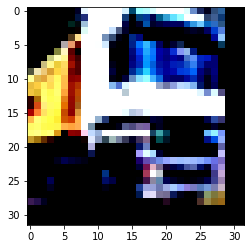

In [9]:
def show_example(img, label):
    print('Label: ', trainset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

show_example(*trainset[1])

In [10]:
import torchvision.models as models
resnet18 = models.resnet18()
resnet18.conv1 = nn.Conv2d(3, 64, kernel_size=(7,7), stride=(2,2), padding=(3,3), bias=False)
resnet18.fc = nn.Linear(in_features=512, out_features=10, bias=True)

#MOMENTUM
resnet18.bn1 = nn.BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)

resnet18.layer1[0].bn1 = nn.BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
resnet18.layer1[0].bn2 = nn.BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
resnet18.layer1[1].bn1 = nn.BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
resnet18.layer1[1].bn2 = nn.BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)

resnet18.layer2[0].bn1 = nn.BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
resnet18.layer2[0].bn2 = nn.BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
resnet18.layer2[1].bn1 = nn.BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
resnet18.layer2[1].bn2 = nn.BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
resnet18.layer2[0].downsample[1] = nn.GroupNorm(32, 128)

resnet18.layer3[0].bn1 = nn.BatchNorm2d(256, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
resnet18.layer3[0].bn2 = nn.BatchNorm2d(256, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
resnet18.layer3[1].bn1 = nn.BatchNorm2d(256, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
resnet18.layer3[1].bn2 = nn.BatchNorm2d(256, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
resnet18.layer3[0].downsample[1] = nn.BatchNorm2d(256, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)

resnet18.layer4[0].bn1 = nn.BatchNorm2d(512, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
resnet18.layer4[0].bn2 = nn.BatchNorm2d(512, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
resnet18.layer4[1].bn1 = nn.BatchNorm2d(512, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
resnet18.layer4[1].bn2 = nn.BatchNorm2d(512, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
resnet18.layer4[0].downsample[1] = nn.BatchNorm2d(512, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)

# Create the model
model = resnet18
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
list(model.parameters())

[Parameter containing:
 tensor([[[[-6.2180e-02,  7.0014e-02, -1.7035e-02,  ...,  1.5838e-02,
            -2.2939e-02,  5.2414e-02],
           [-4.3869e-02, -6.0750e-02, -2.4431e-02,  ..., -7.5639e-02,
            -2.1741e-02,  1.6168e-02],
           [-3.1244e-02, -1.4783e-02, -5.4932e-02,  ..., -1.7755e-02,
             1.4109e-02, -5.7983e-02],
           ...,
           [-3.5194e-02, -2.4709e-02, -3.9488e-02,  ...,  2.0835e-02,
            -5.3458e-02,  3.5728e-02],
           [-7.7013e-02, -9.4114e-05, -4.8205e-02,  ..., -2.7180e-02,
             1.7816e-02, -6.5311e-02],
           [ 3.2495e-02,  5.6344e-02, -2.8626e-02,  ...,  2.7954e-02,
             3.6116e-02,  2.7394e-02]],
 
          [[ 2.8217e-02, -2.6394e-02, -4.3001e-02,  ..., -6.3680e-02,
             2.9411e-02,  1.5369e-02],
           [-7.9128e-02,  5.5824e-02, -8.1355e-02,  ...,  2.8385e-02,
             7.9422e-02,  2.1540e-02],
           [-2.3748e-02,  2.5476e-02,  3.2575e-02,  ..., -7.4231e-02,
             3.4

In [12]:
def init_params(net):
    '''Init layer parameters.'''
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            init.kaiming_normal(m.weight, mode='fan_out')
            if m.bias:
                init.constant(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            init.constant(m.weight, 1)
            init.constant(m.bias, 0)
        elif isinstance(m, nn.Linear):
            init.kaiming_uniform(m.weight, mode="fan_in")
            #if m.bias:
                #init.kaiming_uniform(m.weight, mode="fan_in")

In [13]:
import torch.nn.init as init
init_params(model)

/tmp/ipykernel_674677/1833904545.py:5: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(m.weight, mode='fan_out')
/tmp/ipykernel_674677/1833904545.py:9: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(m.weight, 1)
/tmp/ipykernel_674677/1833904545.py:10: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(m.bias, 0)
/tmp/ipykernel_674677/1833904545.py:12: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  init.kaiming_uniform(m.weight, mode="fan_in")


In [14]:
torch.cuda.is_available()

dev = torch.device('cuda')
print(dev)

cuda


In [15]:
num_epochs=200

In [16]:
# Define an optimizier
import torch.optim as optim
#optimizer = optim.SGD([x for x in model.parameters() if x.requires_grad], lr = 0.1, momentum=0.9, weight_decay=0.0005)
optimizer = optim.Adam([x for x in model.parameters() if x.requires_grad], lr=0.0001)
#optimizer = optim.AdamW([x for x in model.parameters() if x.requires_grad], lr=0.001, weight_decay=0.02)
# Define a loss 
criterion = nn.CrossEntropyLoss()
#scheduler
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = 0.01, epochs=2, steps_per_epoch=312)



In [17]:
def train(net, loaders, optimizer, criterion, epochs=100, dev=torch.device('cuda')):
    try:
        net = net.to(dev)
        print(net)
        # Initialize history
        history_loss = {"train": [], "val": [], "test": []}
        history_accuracy = {"train": [], "val": [], "test": []}
        # Process each epoch
        for epoch in range(epochs):
            # Initialize epoch variables
            sum_loss = {"train": 0, "val": 0, "test": 0}
            sum_accuracy = {"train": 0, "val": 0, "test": 0}
            # Process each split
            for split in ["train", "val", "test"]:
                # Process each batch
                for (input, labels) in loaders[split]:
                    # Move to CUDA
                    input = input.to(dev)
                    labels = labels.to(dev)
                    # Reset gradients
                    optimizer.zero_grad()
                    # Compute output
                    pred = net(input)
                    loss = criterion(pred, labels)
                    # Update loss
                    sum_loss[split] += loss.item()
                    # Check parameter update
                    if split == "train":
                        # Compute gradients
                        loss.backward()
                        # Optimize
                        optimizer.step()
                    # Compute accuracy
                    _,pred_labels = pred.max(1)
                    batch_accuracy = (pred_labels == labels).sum().item()/input.size(0)
                    # Update accuracy
                    sum_accuracy[split] += batch_accuracy
                scheduler.step()
            # Compute epoch loss/accuracy
            epoch_loss = {split: sum_loss[split]/len(loaders[split]) for split in ["train", "val", "test"]}
            epoch_accuracy = {split: sum_accuracy[split]/len(loaders[split]) for split in ["train", "val", "test"]}
            # Update history
            for split in ["train", "val", "test"]:
                history_loss[split].append(epoch_loss[split])
                history_accuracy[split].append(epoch_accuracy[split])
            # Print info
            print(f"Epoch {epoch+1}:",
                  f"TrL={epoch_loss['train']:.4f},",
                  f"TrA={epoch_accuracy['train']:.4f},",
                  f"VL={epoch_loss['val']:.4f},",
                  f"VA={epoch_accuracy['val']:.4f},",
                  f"TeL={epoch_loss['test']:.4f},",
                  f"TeA={epoch_accuracy['test']:.4f},",
                  f"LR={optimizer.param_groups[0]['lr']:.5f},")
    except KeyboardInterrupt:
        print("Interrupted")
    finally:
        # Plot loss
        plt.title("Loss")
        for split in ["train", "val", "test"]:
            plt.plot(history_loss[split], label=split)
        plt.legend()
        plt.show()
        # Plot accuracy
        plt.title("Accuracy")
        for split in ["train", "val", "test"]:
            plt.plot(history_accuracy[split], label=split)
        plt.legend()
        plt.show()

# Define dictionary of loaders
loaders = {"train": train_loader,
           "val": val_loader,
           "test": test_loader}

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 41: TrL=0.3874, TrA=0.8689, VL=0.6137, VA=0.8092, TeL=0.6415, TeA=0.8017, LR=0.00752,
Epoch 42: TrL=0.3672, TrA=0.8731, VL=0.6173, VA=0.8072, TeL=0.6324, TeA=0.7992, LR=0.00773,
Epoch 43: TrL=0.3728, TrA=0.8728, VL=0.6493, VA=0.7966, TeL=0.6674, TeA=0.7915, LR=0.00793,
Epoch 44: TrL=0.3571, TrA=0.8793, VL=0.6213, VA=0.8063, TeL=0.6573, TeA=0.7950, LR=0.00813,
Epoch 45: TrL=0.3690, TrA=0.8748, VL=0.6628, VA=0.7881, TeL=0.6702, TeA=0.7855, LR=0.00832,
Epoch 46: TrL=0.3741, TrA=0.8715, VL=0.6160, VA=0.8047, TeL=0.6370, TeA=0.8018, LR=0.00850,
Epoch 47: TrL=0.3358, TrA=0.8864, VL=0.5977, VA=0.8144, TeL=0.6111, TeA=0.8099, LR=0.00867,
Epoch 48: TrL=0.3314, TrA=0.8860, VL=0.6500, VA=0.8040, TeL=0.6681, TeA=0.8055, LR=0.00883,
Epoch 49: TrL=0.3266, TrA=0.8876, VL=0.6408, VA=0.8091, TeL=0.6510, TeA=0.8076, LR=0.00899,
Epoch 50: TrL=0.3113, TrA=0.8952, VL=0.5994, VA=0.8116, TeL=0.6344, TeA=0.8126, LR=0.00913,
Epoch 51: TrL=0.3192, TrA=0.8924, VL=0.6295, VA=0.8096, TeL=0.6506, TeA=0.8077, 

Epoch 130: TrL=0.0770, TrA=0.9735, VL=0.7677, VA=0.8488, TeL=0.8028, TeA=0.8438, LR=0.00552,
Epoch 131: TrL=0.0748, TrA=0.9747, VL=0.7532, VA=0.8446, TeL=0.8124, TeA=0.8391, LR=0.00542,
Epoch 132: TrL=0.0715, TrA=0.9754, VL=0.7539, VA=0.8478, TeL=0.7701, TeA=0.8425, LR=0.00531,
Epoch 133: TrL=0.0734, TrA=0.9751, VL=0.7276, VA=0.8458, TeL=0.7626, TeA=0.8469, LR=0.00520,
Epoch 134: TrL=0.0752, TrA=0.9741, VL=0.7246, VA=0.8495, TeL=0.7710, TeA=0.8448, LR=0.00509,
Epoch 135: TrL=0.0685, TrA=0.9758, VL=0.7707, VA=0.8422, TeL=0.8011, TeA=0.8424, LR=0.00499,
Epoch 136: TrL=0.0676, TrA=0.9764, VL=0.7182, VA=0.8495, TeL=0.7522, TeA=0.8495, LR=0.00488,
Epoch 137: TrL=0.0665, TrA=0.9770, VL=0.7817, VA=0.8456, TeL=0.7946, TeA=0.8420, LR=0.00477,
Epoch 138: TrL=0.0635, TrA=0.9780, VL=0.7517, VA=0.8465, TeL=0.7919, TeA=0.8455, LR=0.00466,
Epoch 139: TrL=0.0610, TrA=0.9786, VL=0.7600, VA=0.8497, TeL=0.7752, TeA=0.8496, LR=0.00455,
Epoch 140: TrL=0.0592, TrA=0.9794, VL=0.7435, VA=0.8478, TeL=0.8008, T

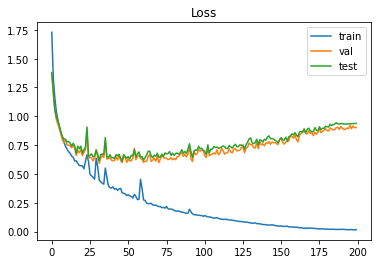

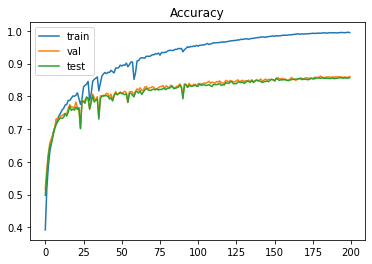

In [18]:
# Train model
train(model, loaders, optimizer, criterion, epochs=num_epochs, dev=dev)